In [ ]:
!pip install kaggle split-folders


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


Copying files: 14034 files [00:02, 5063.56 files/s]


Found 9820 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 2112 images belonging to 6 classes.
58889256/58889256 [==============================] - 4s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


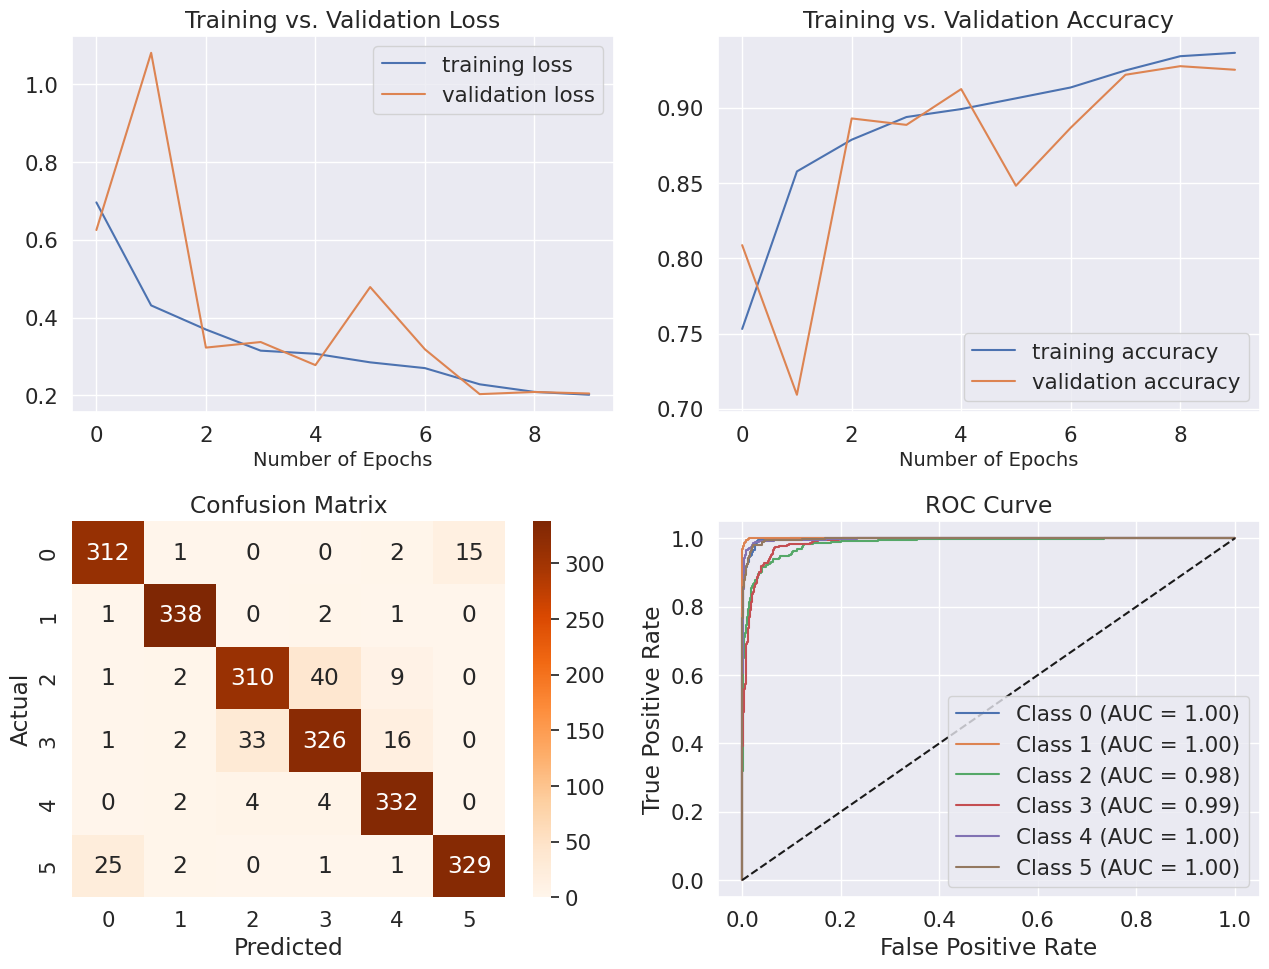

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import pathlib
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up Kaggle API and download the dataset
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'  # replace with your Kaggle username
os.environ['KAGGLE_KEY'] = 'your_kaggle_key'  # replace with your Kaggle API key

!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip the downloaded dataset
with zipfile.ZipFile('intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

import splitfolders

# Function to create dataset for multiclass classification
def create_data_multiclass(data_bs):
    data_bs = pathlib.Path(data_bs)
    splitfolders.ratio(data_bs, output='/kaggle/working/Imgs/', seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)
    data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center=True,
        samplewise_std_normalization=True
    )
    train_ds = data_gen.flow_from_directory('/kaggle/working/Imgs/train/', target_size=(img_height, img_width),
                                            class_mode='categorical', batch_size=batch_size, subset='training')
    val_ds = data_gen.flow_from_directory('/kaggle/working/Imgs/val/', target_size=(img_height, img_width),
                                          class_mode='categorical', batch_size=batch_size, shuffle=False)
    test_ds = data_gen.flow_from_directory('/kaggle/working/Imgs/test/', target_size=(img_height, img_width),
                                           class_mode='categorical', batch_size=batch_size, shuffle=False)
    return train_ds, val_ds, test_ds

# Configuration
epochs = 10
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

# Load data
train_data, val_data, test_data = create_data_multiclass('/kaggle/working/seg_train/seg_train/')

# Load VGG16 model and modify for multiclass classification
vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x = tf.keras.layers.GlobalAveragePooling2D()(vgg.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(train_data.num_classes, activation='softmax')(x)
model_vgg = tf.keras.models.Model(inputs=vgg.input, outputs=x)
model_vgg.summary()
for layer in model_vgg.layers[:15]:
    layer.trainable = False
optimizer = Adam(learning_rate=0.001)
model_vgg.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

# Train the model
history_vgg = model_vgg.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, monitor='val_loss', mode='min',
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=2, monitor='val_loss',
            mode='min', factor=0.1
        )
    ]
)

# Evaluate the model
loss_vgg, acc_vgg = model_vgg.evaluate(test_data)

def create_charts(cnn, cnn_model):
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    train_acc = cnn_model.history['accuracy']
    val_acc = cnn_model.history['val_accuracy']
    y_true = test_data.classes
    Y_pred = cnn.predict(test_data)
    y_pred = np.argmax(Y_pred, axis=1)

    fig = plt.figure(figsize=(13, 10))

    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("Training vs. Validation Accuracy")
    plt.plot(train_acc, label='training accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    plt.subplot(2,2,3)
    cm = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(2,2,4)
    y_true_bin = label_binarize(y_true, classes=[i for i in range(train_data.num_classes)])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(train_data.num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(train_data.num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')


    plt.tight_layout()


    print(classification_report(y_true, y_pred))

create_charts(model_vgg, history_vgg)
model_vgg.save('/kaggle/working/Intel_Image_Classification_VGG16.h5')
